In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, f1_score, roc_auc_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce

import missingno as msno
from prettytable import PrettyTable

In [2]:
# Load Dataset
churn_data = pd.read_csv('Customer-Churn-Records.csv', encoding='utf-8')
print('Number of instances : ', churn_data.shape[0])
print('Number of features : ', churn_data.shape[1])


Number of instances :  10000
Number of features :  18


In [3]:
# Display the first 5 rows
churn_data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [4]:
# Show data summary
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [5]:
# Initialize category and numeric data
category_cols = churn_data.select_dtypes(include=['object']).columns.tolist()
numeric_cols = churn_data.select_dtypes(exclude=['object']).columns.tolist()

In [6]:
# Show statistical summary of numeric data
churn_data.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [7]:
# Show statistical summary of category data
churn_data.describe(include=['object'])

,Surname,Geography,Gender,Card Type
count,10000,10000,10000,10000
unique,2932,3,2,4
top,Smith,France,Male,DIAMOND
freq,32,5014,5457,2507


In [8]:
# Data Preparation and Preprocessing

# Duplicate Value
Duplicated_data_count = churn_data.duplicated().sum()
print('The Duplicate values count is:', Duplicated_data_count)

# Missing Value
Missing_values_count = churn_data.isnull().sum()
print('The Missing Values Count is:\n',Missing_values_count)

The Duplicate values count is: 0
The Missing Values Count is:
 RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


In [9]:
# Feature Engineering
# Create a new column 'Age Group'
bins = [0, 30, 40, 50, 60, np.inf]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

age_bins = np.digitize(churn_data['Age'], bins) - 1
churn_data['Age_Group'] = [labels[i] for i in age_bins]

# Drop Columns
churn_data.drop(['CustomerId','RowNumber', 'Surname'], axis=1, inplace=True)

In [10]:
# Encoding
def one_hot_encode(data, columns):
    encoded_columns = pd.get_dummies(data[columns], prefix=columns)
    return pd.concat([data.drop(columns, axis=1), encoded_columns], axis=1)

def ordinal_encode(data, columns):
    ordinal_encoder = OrdinalEncoder()
    data[columns] = ordinal_encoder.fit_transform(data[columns])
    return data.astype({col: int for col in columns})

def frequency_encode(data, columns):
    frequency_encoder = ce.CountEncoder(cols=columns)
    return frequency_encoder.fit_transform(data)

ordinal_columns = ['Geography', 'Gender', 'Card Type', 'Age_Group']
# Usage
encoded_churn_data = ordinal_encode(churn_data.copy(), ordinal_columns)

encoded_churn_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Age_Group
0,619,0,0,42,2,0.00,1,1,1,101348.88,1,1,2,0,464,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0,1,3,0,456,1
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,1,3,0,377,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0,0,5,1,350,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0,0,5,1,425,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64,0,0,1,0,300,0
9996,516,0,1,35,10,57369.61,1,1,1,101699.77,0,0,5,2,771,0
9997,709,0,0,36,7,0.00,1,0,1,42085.58,1,1,3,3,564,0
9998,772,1,1,42,3,75075.31,2,1,0,92888.52,1,1,2,1,339,1


In [11]:
encoded_churn_data.shape

(10000, 16)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

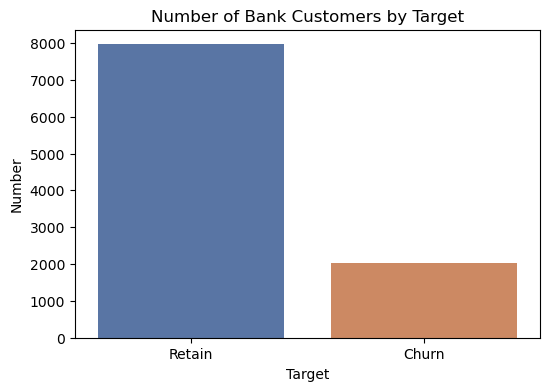

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=encoded_churn_data, palette='deep')
plt.title('Number of Bank Customers by Target')
plt.xlabel('Target')
plt.ylabel('Number')
plt.xticks([0, 1], ['Retain', 'Churn'])
plt.show()


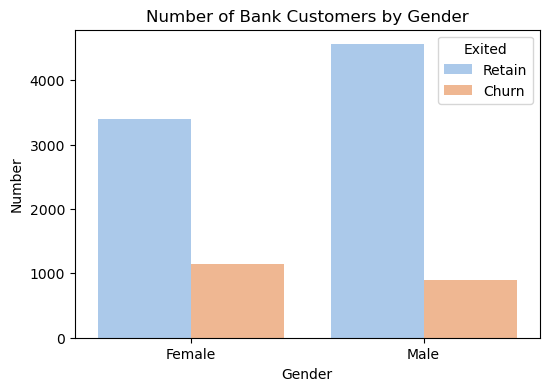

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', hue='Exited', data=churn_data, palette='pastel')
plt.title('Number of Bank Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Number')
plt.legend(title='Exited', labels=['Retain', 'Churn'])
plt.show()


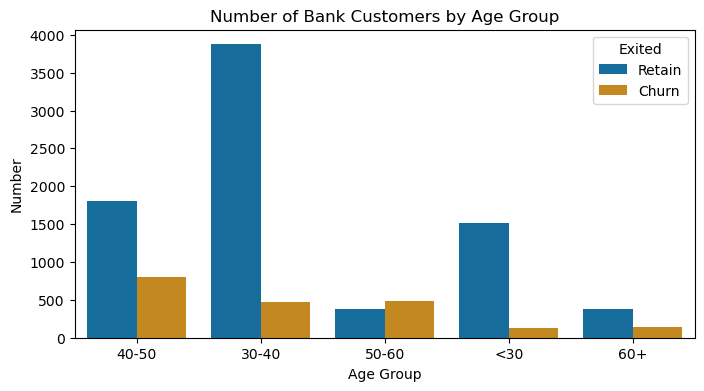

In [14]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Age_Group', hue='Exited', data=churn_data, palette='colorblind')
plt.title('Number of Bank Customers by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number')
plt.legend(title='Exited', labels=['Retain', 'Churn'])
plt.show()


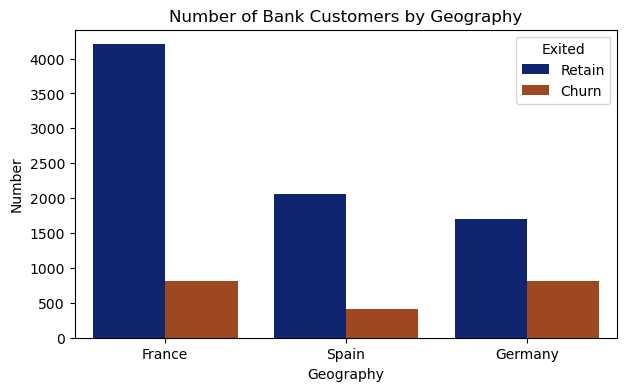

In [15]:
plt.figure(figsize=(7, 4))
sns.countplot(x='Geography', hue='Exited', data=churn_data, palette='dark')
plt.title('Number of Bank Customers by Geography')
plt.xlabel('Geography')
plt.ylabel('Number')
plt.legend(title='Exited', labels=['Retain', 'Churn'])
plt.show()


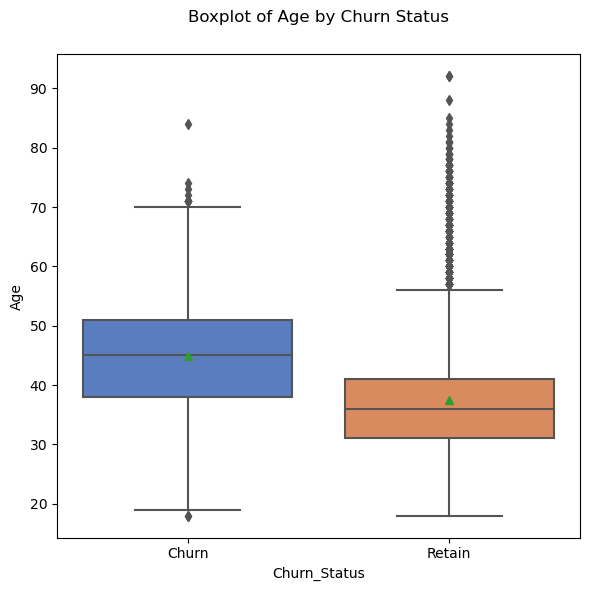

In [16]:
# Prepare the data for the boxplot
churn_data_bivariate = encoded_churn_data.copy()
churn_data_bivariate['Churn_Status'] = churn_data_bivariate['Exited'].map({1: 'Churn', 0: 'Retain'})

# Create the boxplot for Age
plt.figure(figsize=(6, 6))
sns.boxplot(y='Age', x='Churn_Status', showmeans=True, palette='muted', data=churn_data_bivariate)
plt.title('Boxplot of Age by Churn Status', y=1.05)
plt.tight_layout()
plt.show()



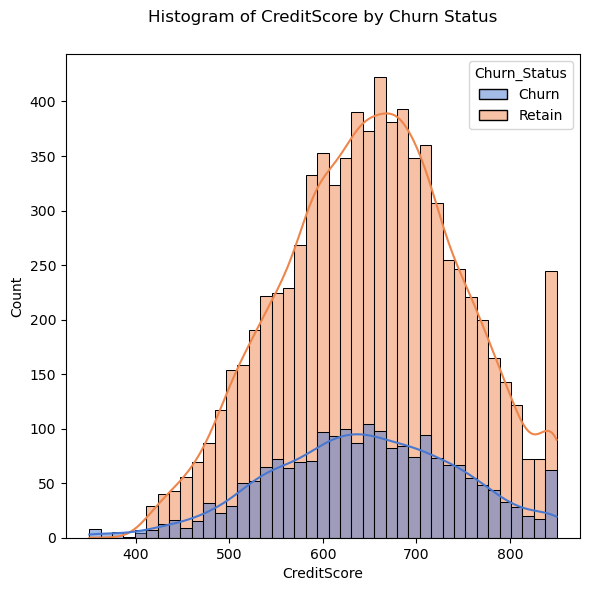

In [17]:
# Histogram for CreditScore
plt.figure(figsize=(6,6))
sns.histplot(data=churn_data_bivariate, x='CreditScore', hue='Churn_Status', kde=True, palette='muted')
plt.title('Histogram of CreditScore by Churn Status', y=1.05)
plt.tight_layout()
plt.show()



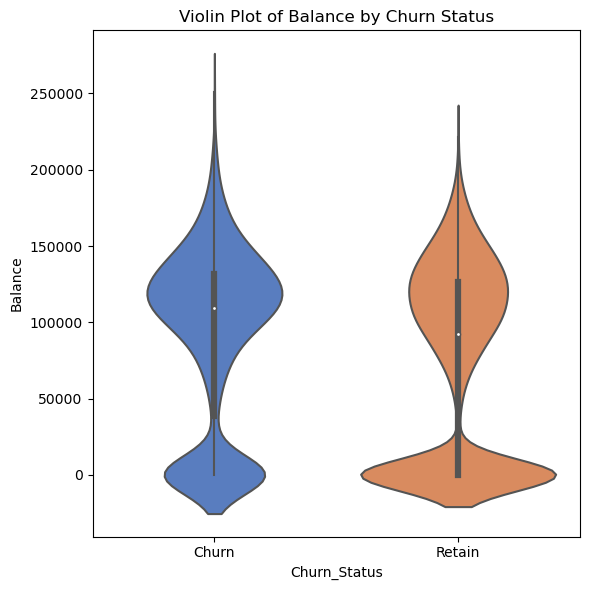

In [18]:
plt.figure(figsize=(6, 6))
sns.violinplot(y='Balance', x='Churn_Status', data=churn_data_bivariate, palette='muted')
plt.title('Violin Plot of Balance by Churn Status')
plt.tight_layout()
plt.show()


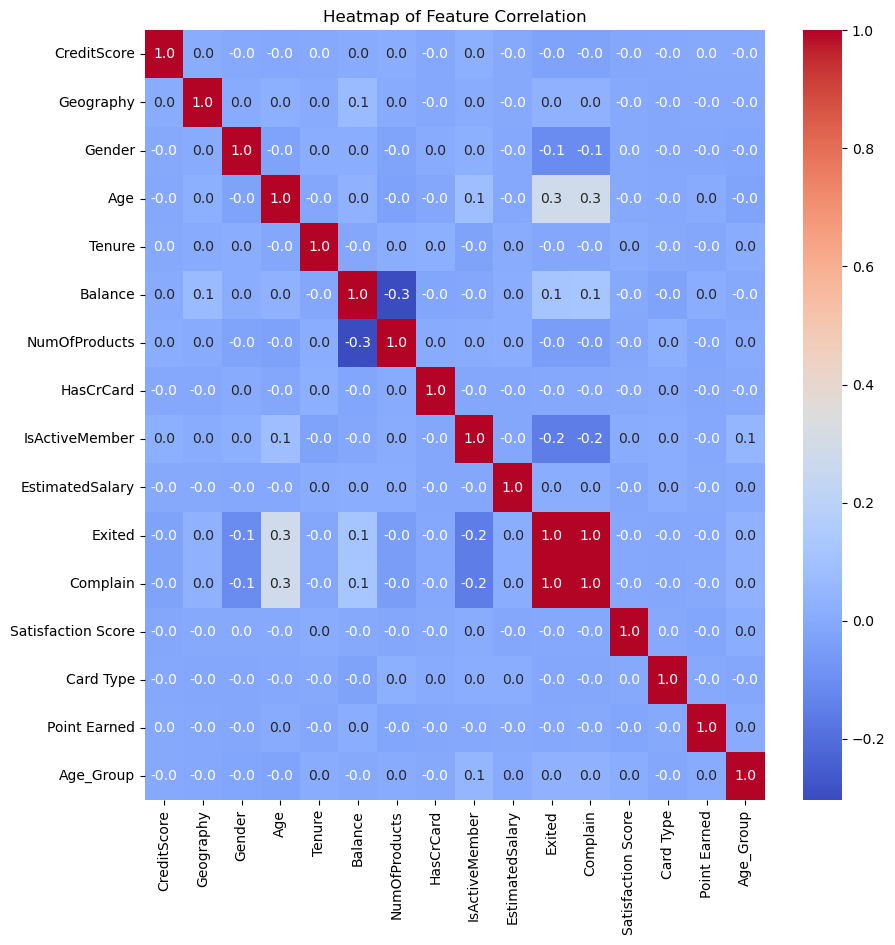

In [19]:
# Correlation Heatmap
plt.figure(figsize=(10, 10))
plt.title('Heatmap of Feature Correlation')

# Plotting the heatmap
sns.heatmap(encoded_churn_data.corr(), annot=True, fmt='.1f', cmap='coolwarm')
plt.show()


In [20]:
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE


# Function to plot the confusion matrix
def plot_confusion_matrix(cm, chart_title):
    plt.figure(figsize=(6, 5))
    plt.suptitle(f'Confusion Matrix - {chart_title}', y=1.05)

    # Labels for each quadrant
    quadrant_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    quadrant_short = ['(TN)', '(FP)', '(FN)', '(TP)']
    quadrant_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]

    # Combine labels
    combined_labels = [f"{label}\n{short}\n{percent}" for label, short, percent in zip(quadrant_labels, quadrant_short, quadrant_percentages)]
    combined_labels = np.asarray(combined_labels).reshape(2, 2)

    # Create a heatmap
    sns.heatmap(cm, annot=combined_labels, fmt='', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

# Train Test Splitting
sns.set_theme(style="white")

# Initialize X as features and y as target from 'encoded_churn_data'
X = encoded_churn_data.drop(['Exited'], axis=1).values
y = encoded_churn_data['Exited'].values

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)

# Sampling
print("Original dataset target distribution:", Counter(y_train))

# Initialize a SMOTE instance for Oversampling
smote_sampler = SMOTE()
# Perform undersampling using NearMiss
X_train_resampled, y_train_resampled = smote_sampler.fit_resample(X_train, y_train)
print("Resampled dataset target distribution:", Counter(y_train_resampled))


Original dataset target distribution: Counter({0: 5573, 1: 1427})
Resampled dataset target distribution: Counter({0: 5573, 1: 5573})


--------------------------------------------------
Recall       : 0.7528641571194763
ROC-AUC Score: 0.7052307390871555
--------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.66      0.76      2389
           1       0.36      0.75      0.49       611

    accuracy                           0.68      3000
   macro avg       0.64      0.71      0.63      3000
weighted avg       0.80      0.68      0.71      3000

--------------------------------------------------
Confusion Matrix:

 [[1571  818]
 [ 151  460]]
--------------------------------------------------


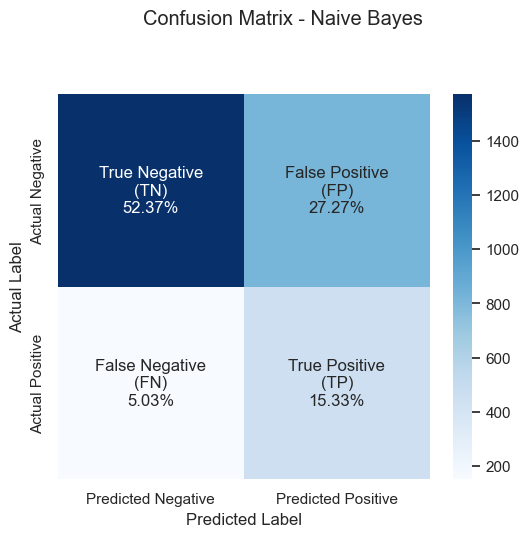

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, roc_auc_score, classification_report, confusion_matrix

# Initialize the Naive Bayes classifier and fit it to the resampled training data
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_nb = naive_bayes_classifier.predict(X_test)

# Calculate metric evaluation and confusion matrix
recall_nb = recall_score(y_test, y_pred_nb)
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Print the results
print("-" * 50)
print("Recall       :", recall_nb)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_nb))
print("-" * 50)
print("Classification Report:\n\n", classification_report(y_test, y_pred_nb))
print("-" * 50)
print("Confusion Matrix:\n\n", cm_nb)
print("-" * 50)

# Chart title for Naive Bayes
chart_title_nb = 'Naive Bayes'

# Plot the confusion matrix
plot_confusion_matrix(cm_nb, chart_title_nb)


--------------------------------------------------
Recall       : 0.9934533551554828
ROC-AUC Score: 0.9956802146225301
--------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2389
           1       0.99      0.99      0.99       611

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

--------------------------------------------------
Confusion Matrix:

 [[2384    5]
 [   4  607]]
--------------------------------------------------


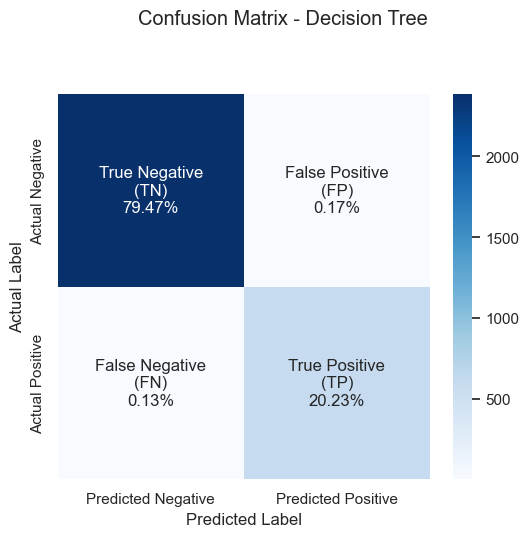

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier and fit it to the resampled training data
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_dt = decision_tree_classifier.predict(X_test)

# Calculate metric evaluation and confusion matrix
recall_dt = recall_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Print the results
print("-" * 50)
print("Recall       :", recall_dt)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_dt))
print("-" * 50)
print("Classification Report:\n\n", classification_report(y_test, y_pred_dt))
print("-" * 50)
print("Confusion Matrix:\n\n", cm_dt)
print("-" * 50)

# Chart title for Decision Tree
chart_title_dt = 'Decision Tree'

# Plot the confusion matrix
plot_confusion_matrix(cm_dt, chart_title_dt)


-------------------------------------------------------
Recall       : 0.9983633387888707
ROC-AUC Score: 0.9981352064392239
-------------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2389
           1       0.99      1.00      1.00       611

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

-------------------------------------------------------
Confusion Matrix:

 [[2384    5]
 [   1  610]]
-------------------------------------------------------


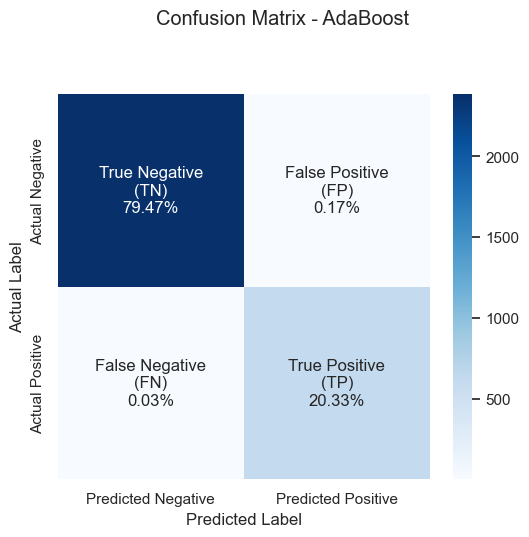

In [25]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost classifier and fit it to the resampled training data
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_ada = adaboost_classifier.predict(X_test)

# Calculate metric evaluation and confusion matrix
recall_ada = recall_score(y_test, y_pred_ada)
cm_ada = confusion_matrix(y_test, y_pred_ada)

# Print the results
print("-" * 55)
print("Recall       :", recall_ada)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_ada))
print("-" * 55)
print("Classification Report:\n\n", classification_report(y_test, y_pred_ada))
print("-" * 55)
print("Confusion Matrix:\n\n", cm_ada)
print("-" * 55)

# Chart title for AdaBoost
chart_title_ada = 'AdaBoost'

# Plot the confusion matrix
plot_confusion_matrix(cm_ada, chart_title_ada)


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# Initialize a K-Fold cross-validation object with 10 folds
kfold_cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [26]:
# Compute the cross-validation recall scores and ROC-AUC scores for the untuned AdaBoost classifier
cv_recall_scores_ada = cross_val_score(adaboost_classifier, X_train_resampled, y_train_resampled, cv=kfold_cv, n_jobs=-1, scoring='recall').mean()
cv_rocauc_scores_ada = cross_val_score(adaboost_classifier, X_train_resampled, y_train_resampled, cv=kfold_cv, n_jobs=-1, scoring='roc_auc').mean()

# Print the cross-validation results
chart_title_ada_cv = 'AdaBoost'
print(f"The cross-validation recall and ROC-AUC score for untuned {chart_title_ada_cv} after a 10-fold cross-validation:")
print("Recall   :", cv_recall_scores_ada)
print("ROC-AUC  :", cv_rocauc_scores_ada)


The cross-validation recall and ROC-AUC score for untuned AdaBoost after a 10-fold cross-validation:
Recall   : 0.9991129795902033
ROC-AUC  : 0.9997873405365718


In [27]:
print(adaboost_classifier.get_params())

{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}


In [28]:
# Define the parameter grid for hyperparameter tuning
param_grid_ada = {
    'n_estimators': [100, 300, 500, 600],
    'learning_rate': [0.01, 0.08, 0.1, 0.5, 1.0]
}

# Initialize GridSearchCV objects for recall and ROC-AUC score
grid_recall_ada = GridSearchCV(adaboost_classifier, param_grid_ada, cv=kfold_cv, n_jobs=-1, scoring='recall')
grid_rocauc_ada = GridSearchCV(adaboost_classifier, param_grid_ada, cv=kfold_cv, n_jobs=-1, scoring='roc_auc')

# Perform grid search for recall and ROC-AUC score
grid_recall_ada.fit(X_train_resampled, y_train_resampled)
grid_rocauc_ada.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters for recall and ROC-AUC
best_hyperparams_recall_ada = grid_recall_ada.best_params_
best_hyperparams_rocauc_ada = grid_rocauc_ada.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall_ada)
print("ROC-AUC  :\n", best_hyperparams_rocauc_ada)

# Cross-validation scores for the tuned model
cv_recall_score_ada_tuned = grid_recall_ada.best_score_
cv_rocauc_score_ada_tuned = grid_rocauc_ada.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned AdaBoost after a 10-fold cross-validation:")
print("Recall :", cv_recall_score_ada_tuned)
print("ROC-AUC  :", cv_rocauc_score_ada_tuned)

# Best AdaBoost model
best_ada_model = grid_recall_ada.best_estimator_

# Cross-validation scores for the best model on train data
cv_recall_train_ada = cross_val_score(best_ada_model, X_train_resampled, y_train_resampled, cv=kfold_cv, n_jobs=-1, scoring='recall').mean()
cv_rocauc_train_ada = cross_val_score(best_ada_model, X_train_resampled, y_train_resampled, cv=kfold_cv, n_jobs=-1, scoring='roc_auc').mean()

print("=" * 55)
print("Train Data")
print("Recall   :", cv_recall_train_ada)
print("ROC-AUC  :", cv_rocauc_train_ada)

# Cross-validation scores for the best model on test data
cv_recall_test_ada = cross_val_score(best_ada_model, X_test, y_test, cv=kfold_cv, n_jobs=-1, scoring='recall').mean()
cv_rocauc_test_ada = cross_val_score(best_ada_model, X_test, y_test, cv=kfold_cv, n_jobs=-1, scoring='roc_auc').mean()

print("-" * 50)
print("Test Data")
print("Recall   :", cv_recall_test_ada)
print("ROC-AUC  :", cv_rocauc_test_ada)


Best hyperparameters for recall and ROC-AUC:
Recall :
 {'learning_rate': 0.5, 'n_estimators': 300}
ROC-AUC  :
 {'learning_rate': 0.01, 'n_estimators': 600}

The cross-validation recall and ROC-AUC score for tuned AdaBoost after a 10-fold cross-validation:
Recall : 0.999465286472117
ROC-AUC  : 0.9998443423208508
Train Data
Recall   : 0.999465286472117
ROC-AUC  : 0.9996924999754592
--------------------------------------------------
Test Data
Recall   : 0.9966758241758242
ROC-AUC  : 0.9984229908513603


In [29]:
# Create a DataFrame to store the predictions
predictions_ada = pd.DataFrame({'Prediction': best_ada_model.predict(encoded_churn_data.drop('Exited', axis=1))})

# Concatenate the predictions with the original training DataFrame
result_ada = pd.concat([predictions_ada, encoded_churn_data], axis=1).rename(columns={'Exited': 'Actual', 'Prediction': 'Predicted'})

# Selecting the desired columns for the result DataFrame
columns_to_select = ['Actual', 'Predicted','Gender', 'Age', 'Geography', 'Tenure', 'CreditScore', 
                     'Balance', 'NumOfProducts', 'HasCrCard', 'Card Type', 'IsActiveMember', 'EstimatedSalary', 
                     'Complain', 'Satisfaction Score', 'Point Earned']
result_ada = result_ada[columns_to_select]

# Map the numerical labels to their corresponding Churn status
result_ada['Exited (Actual)'] = result_ada['Actual'].map({1: 'Churn', 0: 'Retain'})
result_ada['Exited (Predicted)'] = result_ada['Predicted'].map({1: 'Churn', 0: 'Retain'})

result_ada.head()


,Actual,Predicted,Gender,Age,Geography,Tenure,CreditScore,Balance,NumOfProducts,HasCrCard,Card Type,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Point Earned,Exited (Actual),Exited (Predicted)
0,1,1,0,42,0,2,619,0.00,1,1,0,1,101348.88,1,2,464,Churn,Churn
1,0,0,0,41,2,1,608,83807.86,1,0,0,1,112542.58,1,3,456,Retain,Retain
2,1,1,0,42,0,8,502,159660.80,3,1,0,0,113931.57,1,3,377,Churn,Churn
3,0,0,0,39,0,1,699,0.00,2,0,1,0,93826.63,0,5,350,Retain,Retain
4,0,0,0,43,2,2,850,125510.82,1,1,1,1,79084.10,0,5,425,Retain,Retain


            Feature  Importance
10         Complain        0.24
9   EstimatedSalary        0.18
0       CreditScore        0.14
5           Balance        0.10
3               Age        0.06
4            Tenure        0.06
6     NumOfProducts        0.06
8    IsActiveMember        0.04
13     Point Earned        0.04
1         Geography        0.02


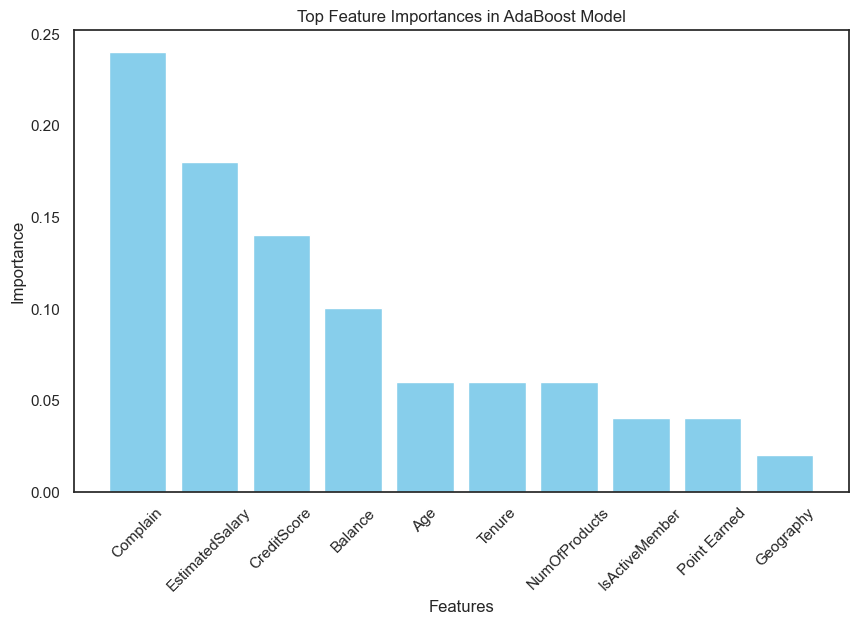

In [30]:
# Extracting feature importances
feature_importances_ada = adaboost_classifier.feature_importances_

# Assuming the feature names are the same as in 'encoded_churn_data' minus the target column 'Exited'
feature_names = encoded_churn_data.drop(['Exited'], axis=1).columns

# Creating a DataFrame for visualization
features_ada = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_ada})

# Sorting the DataFrame by importance
features_ada.sort_values(by='Importance', ascending=False, inplace=True)

# Displaying the top 10 features
print(features_ada.head(10))

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances in AdaBoost Model")
plt.bar(features_ada['Feature'][:10], features_ada['Importance'][:10], color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
